Environment check : Should run on 2.x

In [2]:
# Run this to ensure TensorFlow 2.x is used
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  print("version error")
  pass

In [3]:
import json
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

### Set hyperparameter
하이퍼 파라미터를 변수로 설정하여 이 값을 변경하면서 모델을 훈련시키면서 결과값을 보는 연습을 하라.

In [7]:
vocab_size = 10000
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000


### Load data
Course 3에서 달라진 점은, `.csv`와 `.json` 등 여러 포맷의 파일을 직접 입출력받는 부분이다.

In [4]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json \
    -O /tmp/sarcasm.json


--2021-01-18 14:10:31--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.73.208, 172.217.5.240, 172.217.7.144, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.73.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘/tmp/sarcasm.json’

/tmp/sarcasm.json   100%[===================>]   5.38M  --.-KB/s    in 0.05s   

2021-01-18 14:10:31 (107 MB/s) - ‘/tmp/sarcasm.json’ saved [5643545/5643545]



In [5]:
with open("/tmp/sarcasm.json", 'r') as f:
    datastore = json.load(f)

sentences = []
labels = []

for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

### Split data

In [8]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

### Tokenize and Modeling

In [9]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [10]:
# Need this block to get it to work with TensorFlow 2.x
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [11]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length), #임베딩 레이어 추가
    tf.keras.layers.GlobalAveragePooling1D(), #Flatten보다 GlobalAveragePooling1D 사용하기
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [12]:
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 16)           160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 24)                408       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
_________________________________________________________________


### Train and Evaluate

In [13]:
num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/30
625/625 - 5s - loss: 0.6627 - accuracy: 0.5939 - val_loss: 0.5853 - val_accuracy: 0.6701
Epoch 2/30
625/625 - 2s - loss: 0.4448 - accuracy: 0.8271 - val_loss: 0.3930 - val_accuracy: 0.8346
Epoch 3/30
625/625 - 2s - loss: 0.3212 - accuracy: 0.8743 - val_loss: 0.3572 - val_accuracy: 0.8495
Epoch 4/30
625/625 - 2s - loss: 0.2690 - accuracy: 0.8952 - val_loss: 0.3465 - val_accuracy: 0.8553
Epoch 5/30
625/625 - 2s - loss: 0.2337 - accuracy: 0.9091 - val_loss: 0.3410 - val_accuracy: 0.8578
Epoch 6/30
625/625 - 2s - loss: 0.2052 - accuracy: 0.9219 - val_loss: 0.3473 - val_accuracy: 0.8518
Epoch 7/30
625/625 - 2s - loss: 0.1843 - accuracy: 0.9304 - val_loss: 0.3541 - val_accuracy: 0.8538
Epoch 8/30
625/625 - 2s - loss: 0.1663 - accuracy: 0.9379 - val_loss: 0.3714 - val_accuracy: 0.8501
Epoch 9/30
625/625 - 2s - loss: 0.1486 - accuracy: 0.9462 - val_loss: 0.3795 - val_accuracy: 0.8547
Epoch 10/30
625/625 - 2s - loss: 0.1355 - accuracy: 0.9527 - val_loss: 0.3975 - val_accuracy: 0.8512

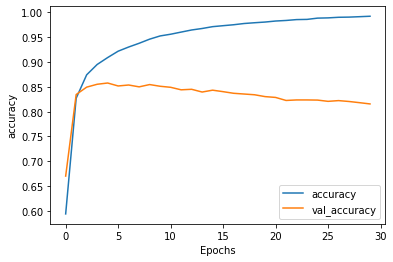

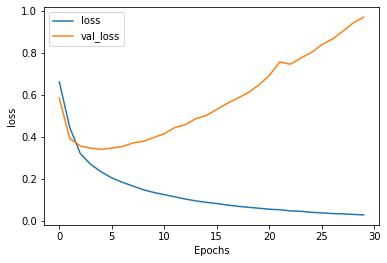

In [14]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

Validatio loss는 오히려 늘어나고 있다.

In [15]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_sentence(training_padded[0]))
print(training_sentences[2])
print(labels[2])

former <OOV> store clerk sues over secret 'black <OOV> for minority shoppers ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
mom starting to fear son's web series closest thing she will have to grandchild
1


In [16]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)


(10000, 16)


### Visualization
projector.tensorflow.org에서 직접 보기

In [17]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [18]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [19]:
sentence = ["granny starting to fear spiders in the garden might be real", "game of thrones season finale showing this sunday night"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model.predict(padded))

[[9.277494e-01]
 [3.609151e-05]]


역시 정확도가 낮아서 그런가 projector로 보면 하나도 잘 분류된 것 같지 않아보인다. 뭔가 되게 오밀조밀하게 모여있음..